In [1]:
import numpy as np
from utils import read_dataset
import matplotlib.pyplot as plt 
import os

In [2]:
dataset = read_dataset("Finn",
                       timestamp="10-12-24--17-14-13",
                       read_ort=True)

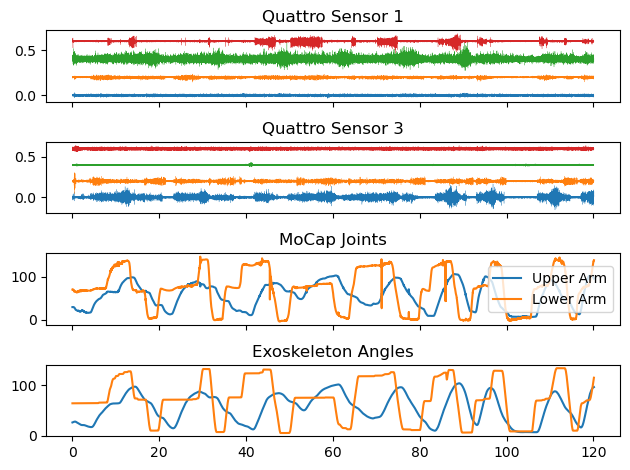

In [3]:
dataset[0].plot(plot_emg=True, plot_mocap_joints=True, plot_ort_angles=True)

In [4]:
dataset[0].mocap_joints.shape, dataset[0].upper_motor_angle.shape, dataset[0].lower_motor_angle.shape

((12010, 2), (5333, 1), (4952, 1))

In [5]:
# resample upper and lower motor angle to match mocap sample rate
x_lower = np.linspace(0, dataset[0].lower_motor_angle.shape[0], dataset[0].mocap_joints.shape[0])

lower_angle = np.interp(x_lower, np.arange(dataset[0].lower_motor_angle.shape[0]), dataset[0].lower_motor_angle[:, 0])

In [6]:
x_upper = np.linspace(0, dataset[0].upper_motor_angle.shape[0], dataset[0].mocap_joints.shape[0])

upper_angle = np.interp(x_upper, np.arange(dataset[0].upper_motor_angle.shape[0]), dataset[0].upper_motor_angle[:, 0])

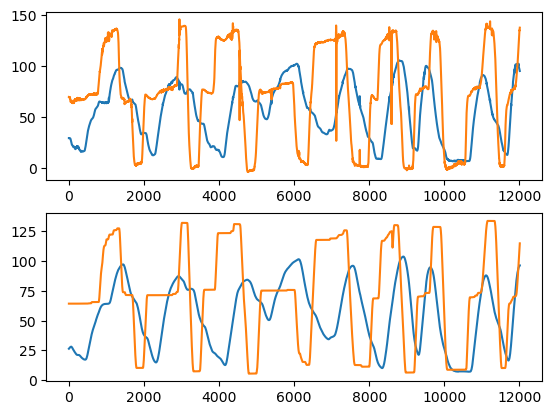

In [7]:
fig, axs = plt.subplots(2)
axs[0].plot(dataset[0].mocap_joints)
axs[1].plot(upper_angle)
axs[1].plot(lower_angle)

In [8]:
# shift measured exoskeleton angles backwards in time and calculcate min rmse 

max_ = 110
mocap = dataset[0].mocap_joints[:-max_, :]
exo_angles = np.vstack((upper_angle, lower_angle)).T
maes = []
min_indices = [0, 0]
min_maes = [float("inf"), float("inf")]
for i in range(max_): 
    mae = np.mean(np.abs((mocap - exo_angles[i:-(max_ - i):])**2), axis=0)
    # mae = np.mean((mocap - exo_angles[i:-(max_ - i):])**2)
    maes.append(mae)
    for j, error in enumerate(mae):
        if error < min_maes[j]: 
            min_maes[j] = error
            min_indices[j] = i

maes = np.array(maes)


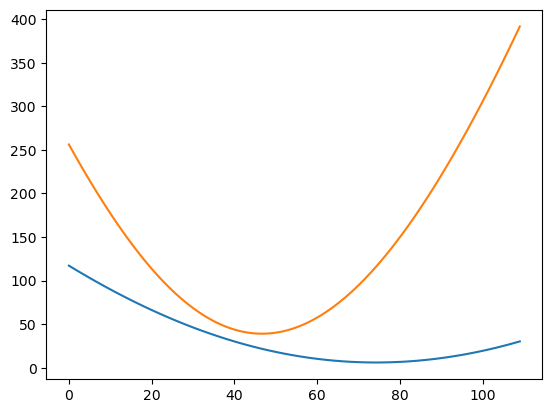

In [9]:
# rmse min is at ~ 50ms 
plt.plot(maes)

In [10]:
export_data = np.c_[np.arange(maes.shape[0])/100, maes]

path = "/home/finn/Documents/LatexMA/data/mae_plot/"

np.savetxt(os.path.join(path, f"mae_time_shift"), export_data, fmt="%f", delimiter=",", header="t_shift, mae_flex, mae_pron", comments="")

In [11]:
min_indices, min_maes

([74, 47], [np.float64(6.015477896507945), np.float64(39.05452049291013)])

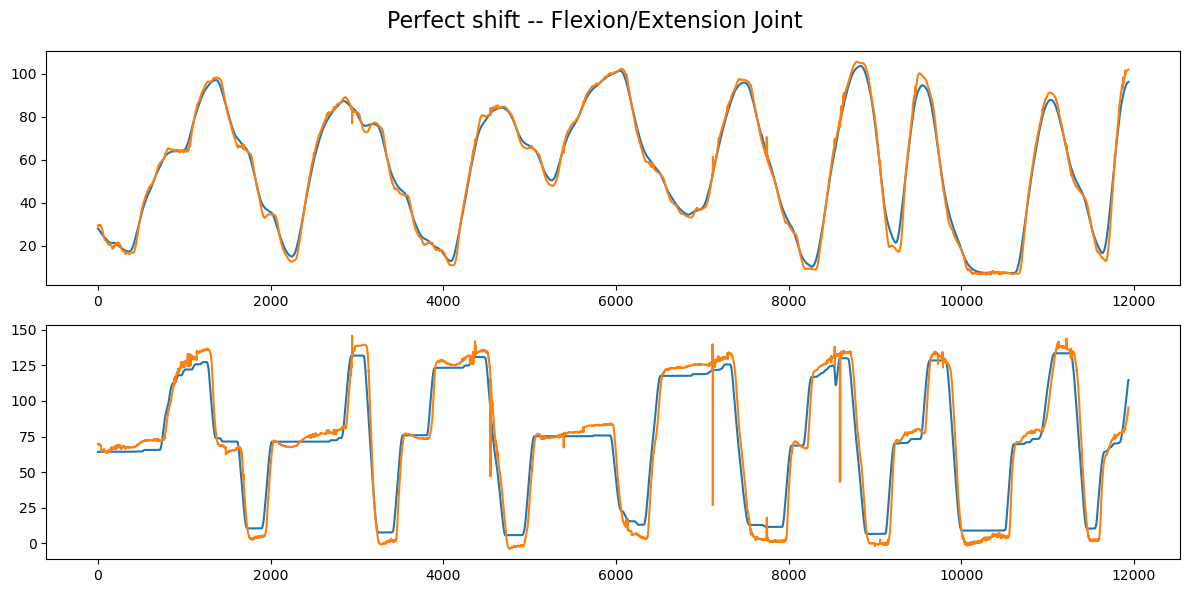

In [12]:
def plot_shift(shift, axs):
    
    axs[0].plot(exo_angles[shift:, 0])
    axs[0].plot(dataset[0].mocap_joints[:-shift, 0])
    axs[1].plot(exo_angles[shift:, 1])
    axs[1].plot(dataset[0].mocap_joints[:-shift, 1])

fig, axs = plt.subplots(2, figsize=(12, 6))
fig.suptitle("Perfect shift -- Flexion/Extension Joint", fontsize=16)
plot_shift(min_indices[0], axs)
plt.tight_layout()

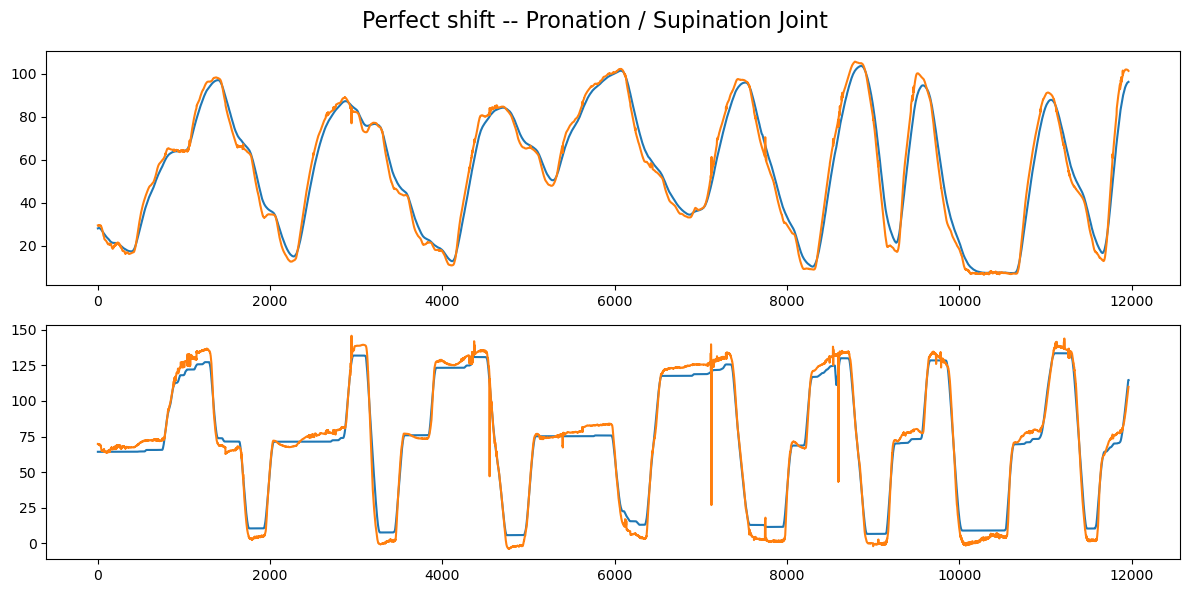

In [13]:
fig, axs = plt.subplots(2, figsize=(12, 6))
fig.suptitle("Perfect shift -- Pronation / Supination Joint", fontsize=16)
plot_shift(min_indices[1], axs)
plt.tight_layout()

In [14]:
# best time shift considering both joints 60 samples --> 600 ms obisouly way too much to use emg as predictor 
best_shift = int(sum(min_indices) / 2)
best_shift

60

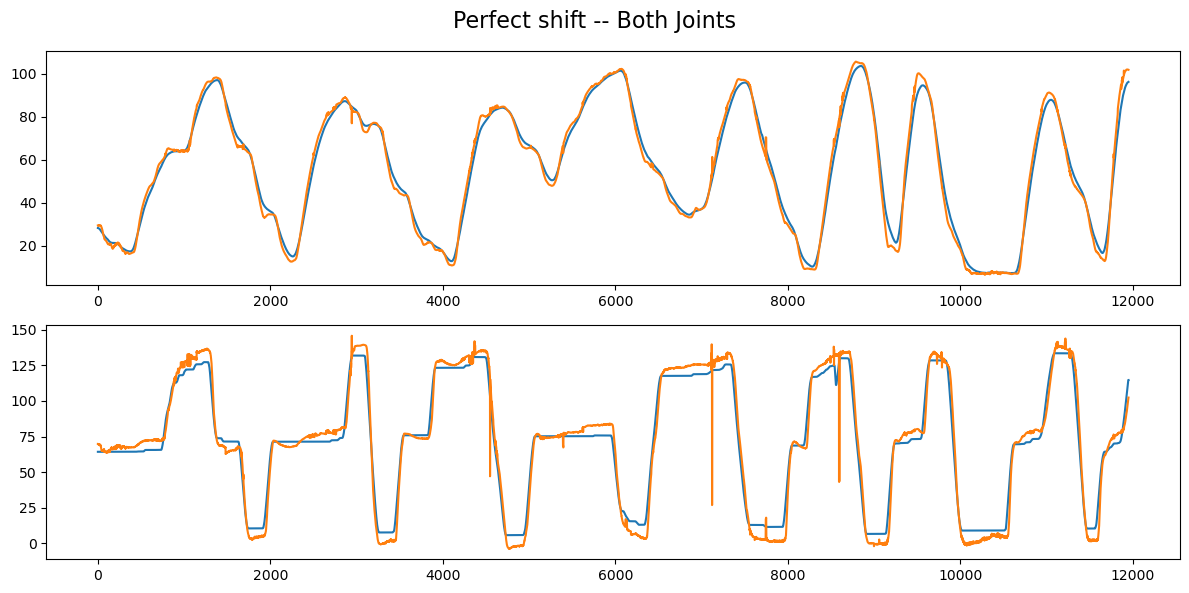

In [15]:
fig, axs = plt.subplots(2, figsize=(12, 6))
fig.suptitle("Perfect shift -- Both Joints", fontsize=16)
plot_shift(best_shift, axs)
plt.tight_layout()

In [16]:
# apply best shift and plot mocap angles and exoskeleton angles in one plot to see min latency


In [17]:
path = "/home/finn/Documents/LatexMA/data/latency_plot/"

def export(shift, save: bool = False): 
    # shift = 10
    cut = 8600
    export_data = np.c_[np.arange(exo_angles.shape[0]-shift)/100, exo_angles[shift:, :], dataset[0].mocap_joints[:-shift, :]]
    export_data = export_data[cut:cut+3000, :]
    export_data[:, 0] = export_data[:, 0] - export_data[0, 0]
    np.savetxt(os.path.join(path, f"data_{shift}_shift"), export_data, fmt="%f", delimiter=",", header="t, exo_flex, exo_pron, real_flex, real_pron", comments="")
    return maes[shift]

In [18]:
export(10)

array([ 89.95425007, 177.26766194])

In [19]:
export(60)

array([10.19873242, 57.51861712])

In [20]:
export(85)

array([  8.36422688, 183.38826346])

In [21]:
maes

array([[117.14365338, 256.27400493],
       [114.27692401, 247.75442132],
       [111.44260301, 239.3674631 ],
       [108.64035597, 231.11546395],
       [105.87046923, 223.00065217],
       [103.13354657, 215.02570793],
       [100.43002796, 207.19056475],
       [ 97.76008831, 199.49016287],
       [ 95.12398366, 191.93746343],
       [ 92.52193419, 184.53109101],
       [ 89.95425007, 177.26766194],
       [ 87.42131966, 170.16036   ],
       [ 84.9236146 , 163.21047663],
       [ 82.46139905, 156.42101197],
       [ 80.03500616, 149.79582247],
       [ 77.64468252, 143.33717386],
       [ 75.29052432, 137.04807331],
       [ 72.97292652, 130.93129514],
       [ 70.69220826, 124.98956904],
       [ 68.44860822, 119.23136164],
       [ 66.24237462, 113.6531015 ],
       [ 64.07352249, 108.26240233],
       [ 61.94210171, 103.06478245],
       [ 59.8481622 ,  98.05556725],
       [ 57.79174562,  93.24320195],
       [ 55.77321539,  88.62517316],
       [ 53.79308729,  84.20487885],
 